In [305]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import pickle
from datetime import datetime

%matplotlib inline
sns.set_style('whitegrid')
# read the cleaned data
data = pd.read_csv("ProcessedData.csv")

#drop car brand names
data_rm_brand = data.drop('Brand', axis=1)

#change car Registration Dates str type to datetime type
data_rm_brand['Registration Date'] = pd.to_datetime(data['Registration Date'])
data_rm_brand['Registration Date'].dtypes

#encode Transmission (Auto='1', Manual='0')
#Define a mapping dictionary
mapping_dict = {'Auto': 1, 'Manual': 0}

# Apply the mapping to the "Transmission" column
data_rm_brand['Transmission'] = data_rm_brand['Transmission'].map(mapping_dict)

#Rename the column to 'Transmission' to reflect encoding
data_rm_brand.rename(columns={'Transmission': 'Transmission'}, inplace=True)

#encode car types
# Define a mapping dictionary
mapping_dict2 = {'Hatchback': 1,'Mid-Sized Sedan': 2, 'MPV': 3, 'Luxury Sedan': 4, 'SUV': 5, 'Sports Car': 6}

# Apply the mapping to the "Vehicle Type" column
data_rm_brand['Vehicle Type'] = data_rm_brand['Vehicle Type'].map(mapping_dict2)

#Rename 'Vehicle Type' to reflect encoding
data_rm_brand.rename(columns={'Vehicle Type': 'Vehicle Type'}, inplace=True)

data_rm_brand.head()

,Price,Depreciation,Road Tax,Registration Date,COE Left,Mileage,Manufacture Year,Transmission,Deregistration,OMV,ARF,COE Price,Engine Capacity,Power,Curb Weight,No. Of Owners,Vehicle Type
0,45800,17150,684,2015-09-30,404,111000,2015,1,25177,26376,23927,61010,1499,100.0,1360,3,1.0
1,14000,13460,620,2014-05-14,213,115000,2013,1,9586,21478,12070,60002,1390,90.0,1417,2,2.0
2,44800,13870,508,2016-10-28,1102,88000,2016,1,18799,14938,5000,50991,1198,72.0,1081,1,1.0
3,75800,17820,684,2017-02-01,1186,90800,2016,1,40186,33244,33542,55501,1499,100.0,1550,2,3.0
4,39888,15910,624,2015-12-29,798,110000,2015,1,17545,19158,9158,54301,1395,90.0,1249,2,1.0


In [306]:
# Convert the Series object to a datetime object using the `to_datetime()` function.
registration_date_datetime = pd.to_datetime(data_rm_brand['Registration Date'], format='%y-%m-%d')

# Encode the registration date to an integer.
encoded_registration_date = registration_date_datetime.dt.year * 10000 + registration_date_datetime.dt.month * 100 + registration_date_datetime.dt.day

print(encoded_registration_date)
encoded_registration_date = encoded_registration_date.astype(int)


0       20150930
1       20140514
2       20161028
3       20170201
4       20151229
          ...   
2958    20170316
2959    20170328
2960    20190723
2961    20151109
2962    20180117
Name: Registration Date, Length: 2963, dtype: int32


In [307]:
# Corr Matrix
data_rm_brand.corr()

,Price,Depreciation,Road Tax,Registration Date,COE Left,Mileage,Manufacture Year,Transmission,Deregistration,OMV,ARF,COE Price,Engine Capacity,Power,Curb Weight,No. Of Owners,Vehicle Type
Price,1.000000,0.405879,0.390903,0.320331,0.473183,-0.438123,0.291822,0.011523,0.486421,0.470934,0.496691,0.224759,0.448740,0.611883,0.393659,-0.072315,0.353179
Depreciation,0.405879,1.000000,0.586243,0.157050,0.072826,-0.261896,0.147556,-0.023524,0.794937,0.859680,0.838527,0.243545,0.654142,0.704537,0.453314,-0.015866,0.281011
Road Tax,0.390903,0.586243,1.000000,-0.270211,0.168138,0.023599,-0.252921,-0.033340,0.474442,0.788761,0.693226,0.155582,0.957364,0.834606,0.643310,0.307436,0.384845
Registration Date,0.320331,0.157050,-0.270211,1.000000,0.336787,-0.767030,0.927686,0.124698,0.364460,0.038120,0.075226,0.239019,-0.139026,-0.022596,0.010461,-0.670616,0.013848
COE Left,0.473183,0.072826,0.168138,0.336787,1.000000,-0.458235,0.291434,-0.020268,0.356746,0.212240,0.171326,0.118988,0.138943,0.192301,0.090604,-0.090974,0.145977
Mileage,-0.438123,-0.261896,0.023599,-0.767030,-0.458235,1.000000,-0.710976,-0.078804,-0.428540,-0.213532,-0.228747,-0.237302,-0.051045,-0.156941,-0.050229,0.512752,-0.083447
Manufacture Year,0.291822,0.147556,-0.252921,0.927686,0.291434,-0.710976,1.000000,0.153483,0.340312,0.036665,0.069355,0.245643,-0.164141,-0.027744,0.004158,-0.634321,-0.003526
Transmission,0.011523,-0.023524,-0.033340,0.124698,-0.020268,-0.078804,0.153483,1.000000,0.001945,-0.002684,-0.010550,0.042483,-0.020774,-0.035271,0.067601,-0.107847,-0.053283
Deregistration,0.486421,0.794937,0.474442,0.364460,0.356746,-0.428540,0.340312,0.001945,1.000000,0.764029,0.825012,0.380672,0.560702,0.641668,0.454746,-0.157855,0.271621
OMV,0.470934,0.859680,0.788761,0.038120,0.212240,-0.213532,0.036665,-0.002684,0.764029,1.000000,0.876838,0.255044,0.812724,0.825119,0.563720,0.100029,0.344961


In [308]:
# How each feature relates to price
data_rm_brand.corr()['Price'].sort_values(ascending=False)

Price                1.000000
Power                0.611883
ARF                  0.496691
Deregistration       0.486421
COE Left             0.473183
OMV                  0.470934
Engine Capacity      0.448740
Depreciation         0.405879
Curb Weight          0.393659
Road Tax             0.390903
Vehicle Type         0.353179
Registration Date    0.320331
Manufacture Year     0.291822
COE Price            0.224759
Transmission         0.011523
No. Of Owners       -0.072315
Mileage             -0.438123
Name: Price, dtype: float64

In [309]:
# Create the data
data = data_rm_brand.corr()

# Extract the correlation values
correlation_values = data.values

# Print the correlation values
for i in range(len(correlation_values)):
    for j in range(len(correlation_values[i])):
        print(f'Correlation between "{data.columns[i]}" and "{data.columns[j]}": {correlation_values[i][j]}')

Correlation between "Price" and "Price": 1.0
Correlation between "Price" and "Depreciation": 0.405879088862114
Correlation between "Price" and "Road Tax": 0.39090319311551763
Correlation between "Price" and "Registration Date": 0.3203310941408325
Correlation between "Price" and "COE Left": 0.47318338681313443
Correlation between "Price" and "Mileage": -0.43812338567151293
Correlation between "Price" and "Manufacture Year": 0.2918219977191553
Correlation between "Price" and "Transmission": 0.011523222367537023
Correlation between "Price" and "Deregistration": 0.486421043017434
Correlation between "Price" and "OMV": 0.4709341338018231
Correlation between "Price" and "ARF": 0.49669056964736846
Correlation between "Price" and "COE Price": 0.22475917957541572
Correlation between "Price" and "Engine Capacity": 0.44873982584069
Correlation between "Price" and "Power": 0.6118831604972524
Correlation between "Price" and "Curb Weight": 0.39365940295473073
Correlation between "Price" and "No. Of 

(17.5, -0.5)

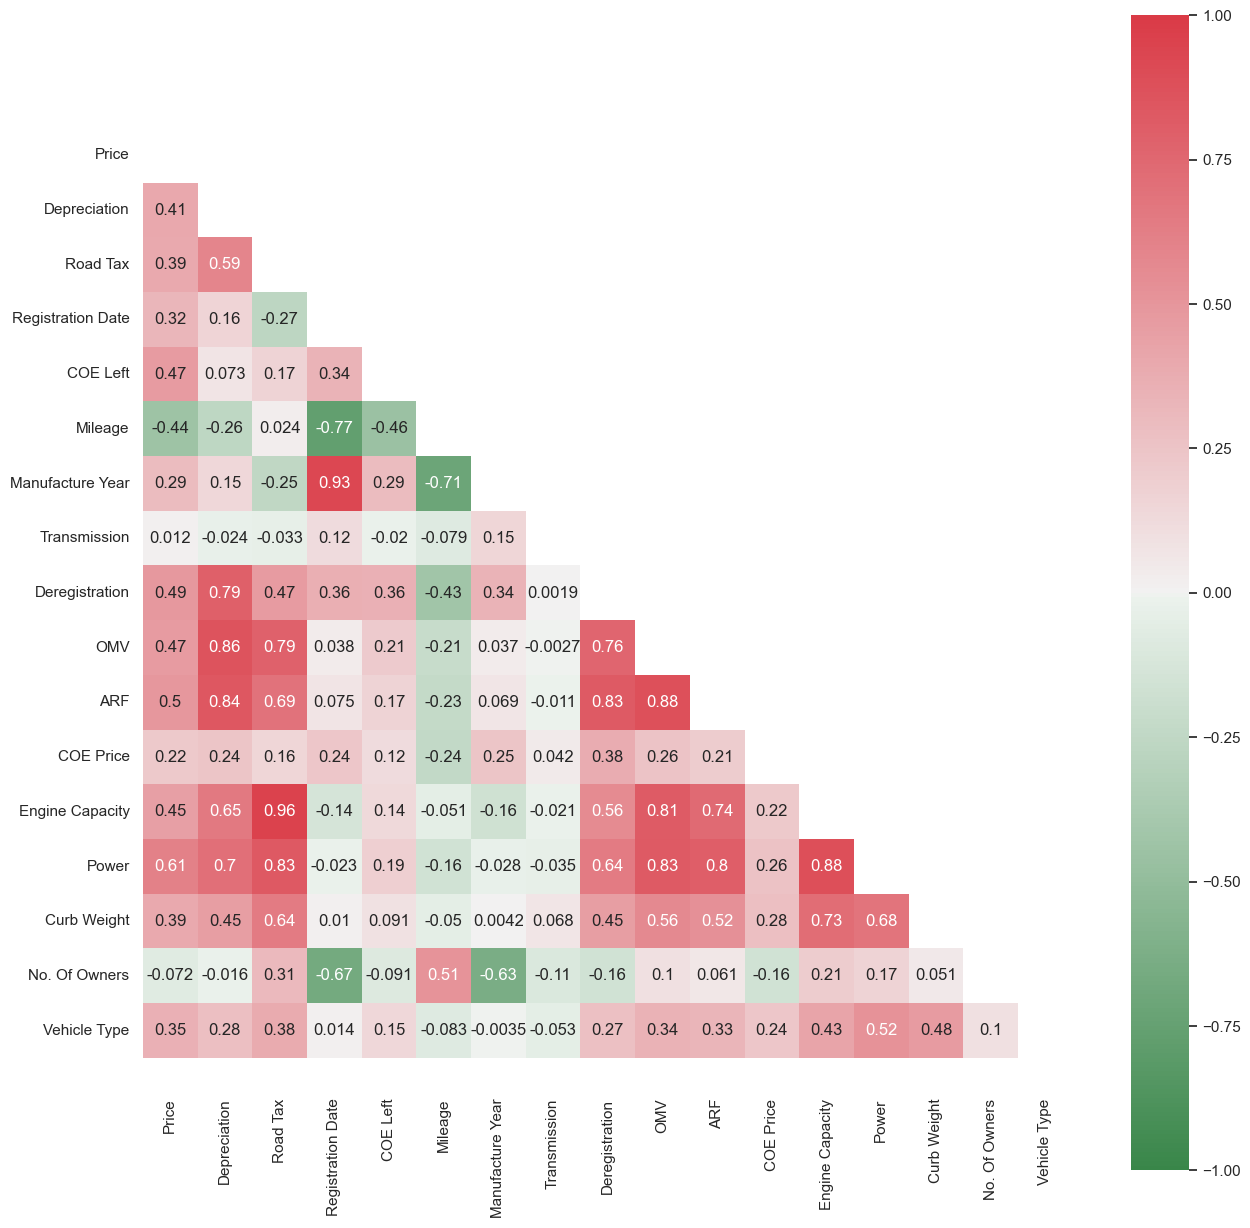

In [310]:
# Corr Matrix Heatmap Visualization

sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(data_rm_brand.corr(), dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure to control size of heatmap
fig, ax = plt.subplots(figsize=(15,15))

# Create a custom color palette
cmap = \
sns.diverging_palette(133, 10, as_cmap=True)  # as_cmap returns a matplotlib colormap object rather than a list of colors
# Green = Good (low correlation), Red = Bad (high correlation) between the independent variables

# Plot the heatmap
sns.heatmap(data_rm_brand.corr(), mask=mask, annot=True, square=True, cmap=cmap , vmin=-1, vmax=1,ax=ax);
# Prevent Heatmap Cut-Off Issue
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)


In [294]:
# Drop the unwanted columns
data_rm_brand.drop(['Depreciation','Registration Date','Manufacture Year','ARF','Engine Capacity','Power'],axis=1,inplace=True)

# Get the remaining columns
remaining_columns = data_rm_brand.columns

# Save the remaining columns to a CSV file
data_rm_brand.to_csv('remaining_columns.csv', index=False, columns=remaining_columns)


(11.5, -0.5)

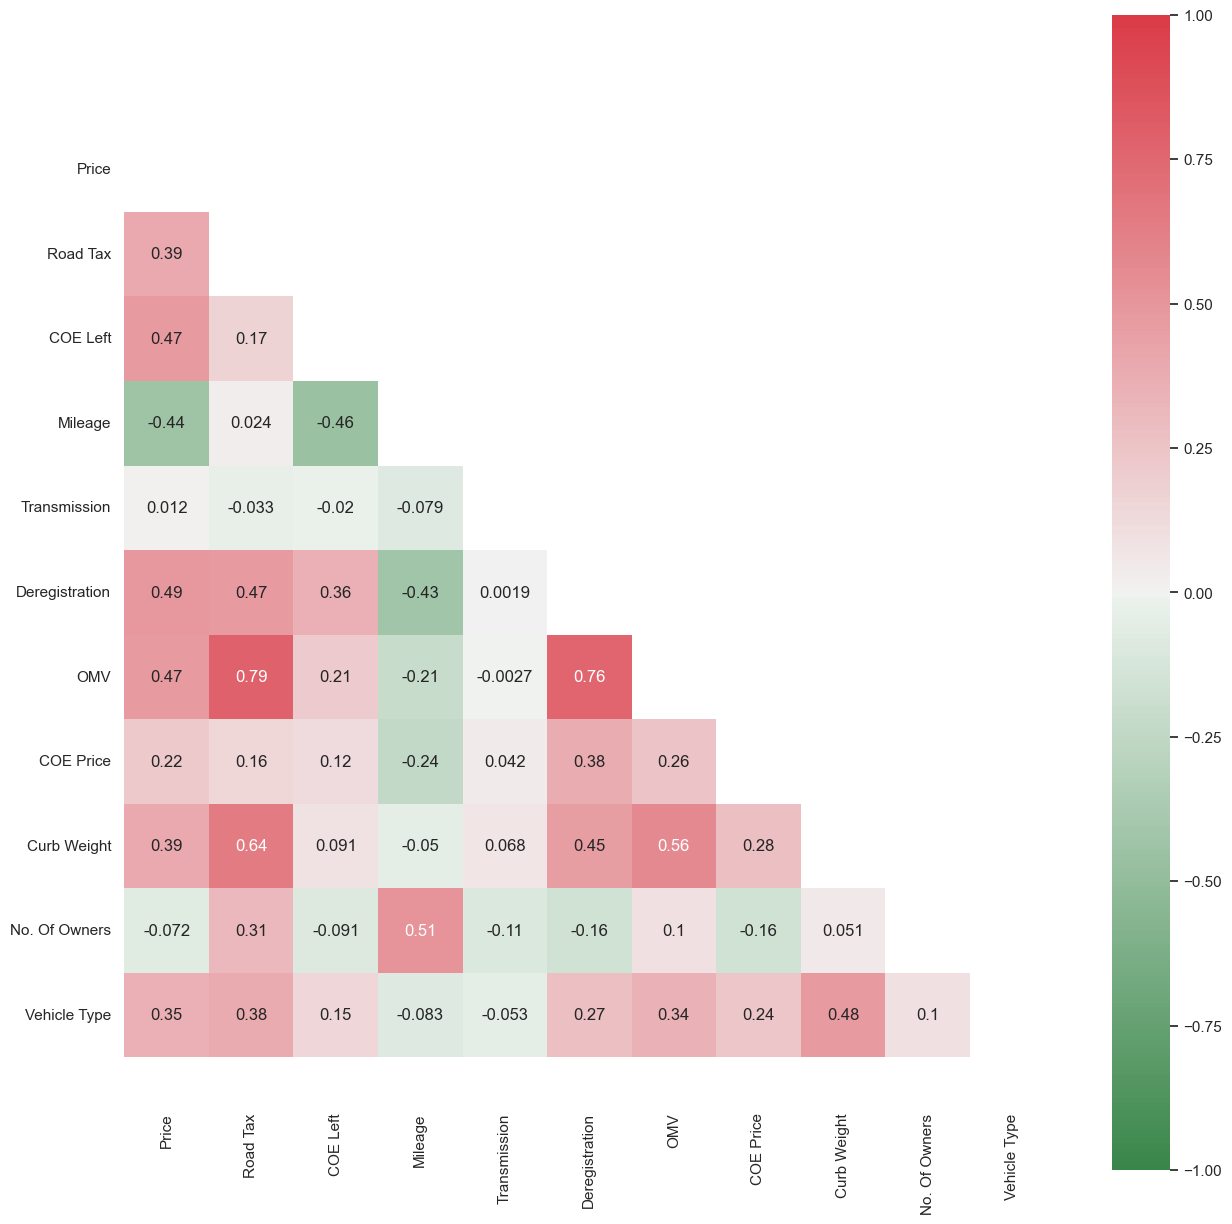

In [295]:
# Re-visualizing the correlation matrix

sns.set(style="white")

# Creating the data
data = data_rm_brand.corr()


# Generate a mask for the upper triangle
mask = np.zeros_like(data, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure to control size of heatmap
fig, ax = plt.subplots(figsize=(15,15))

# Create a custom color palette
cmap = \
sns.diverging_palette(133, 10, as_cmap=True)  # as_cmap returns a matplotlib colormap object rather than a list of colors
# Green = Good (low correlation), Red = Bad (high correlation) between the independent variables

# Plot the heatmap
sns.heatmap(data, mask=mask, annot=True, square=True, cmap=cmap , vmin=-1, vmax=1,ax=ax);

# Prevent Heatmap Cut-Off Issue
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

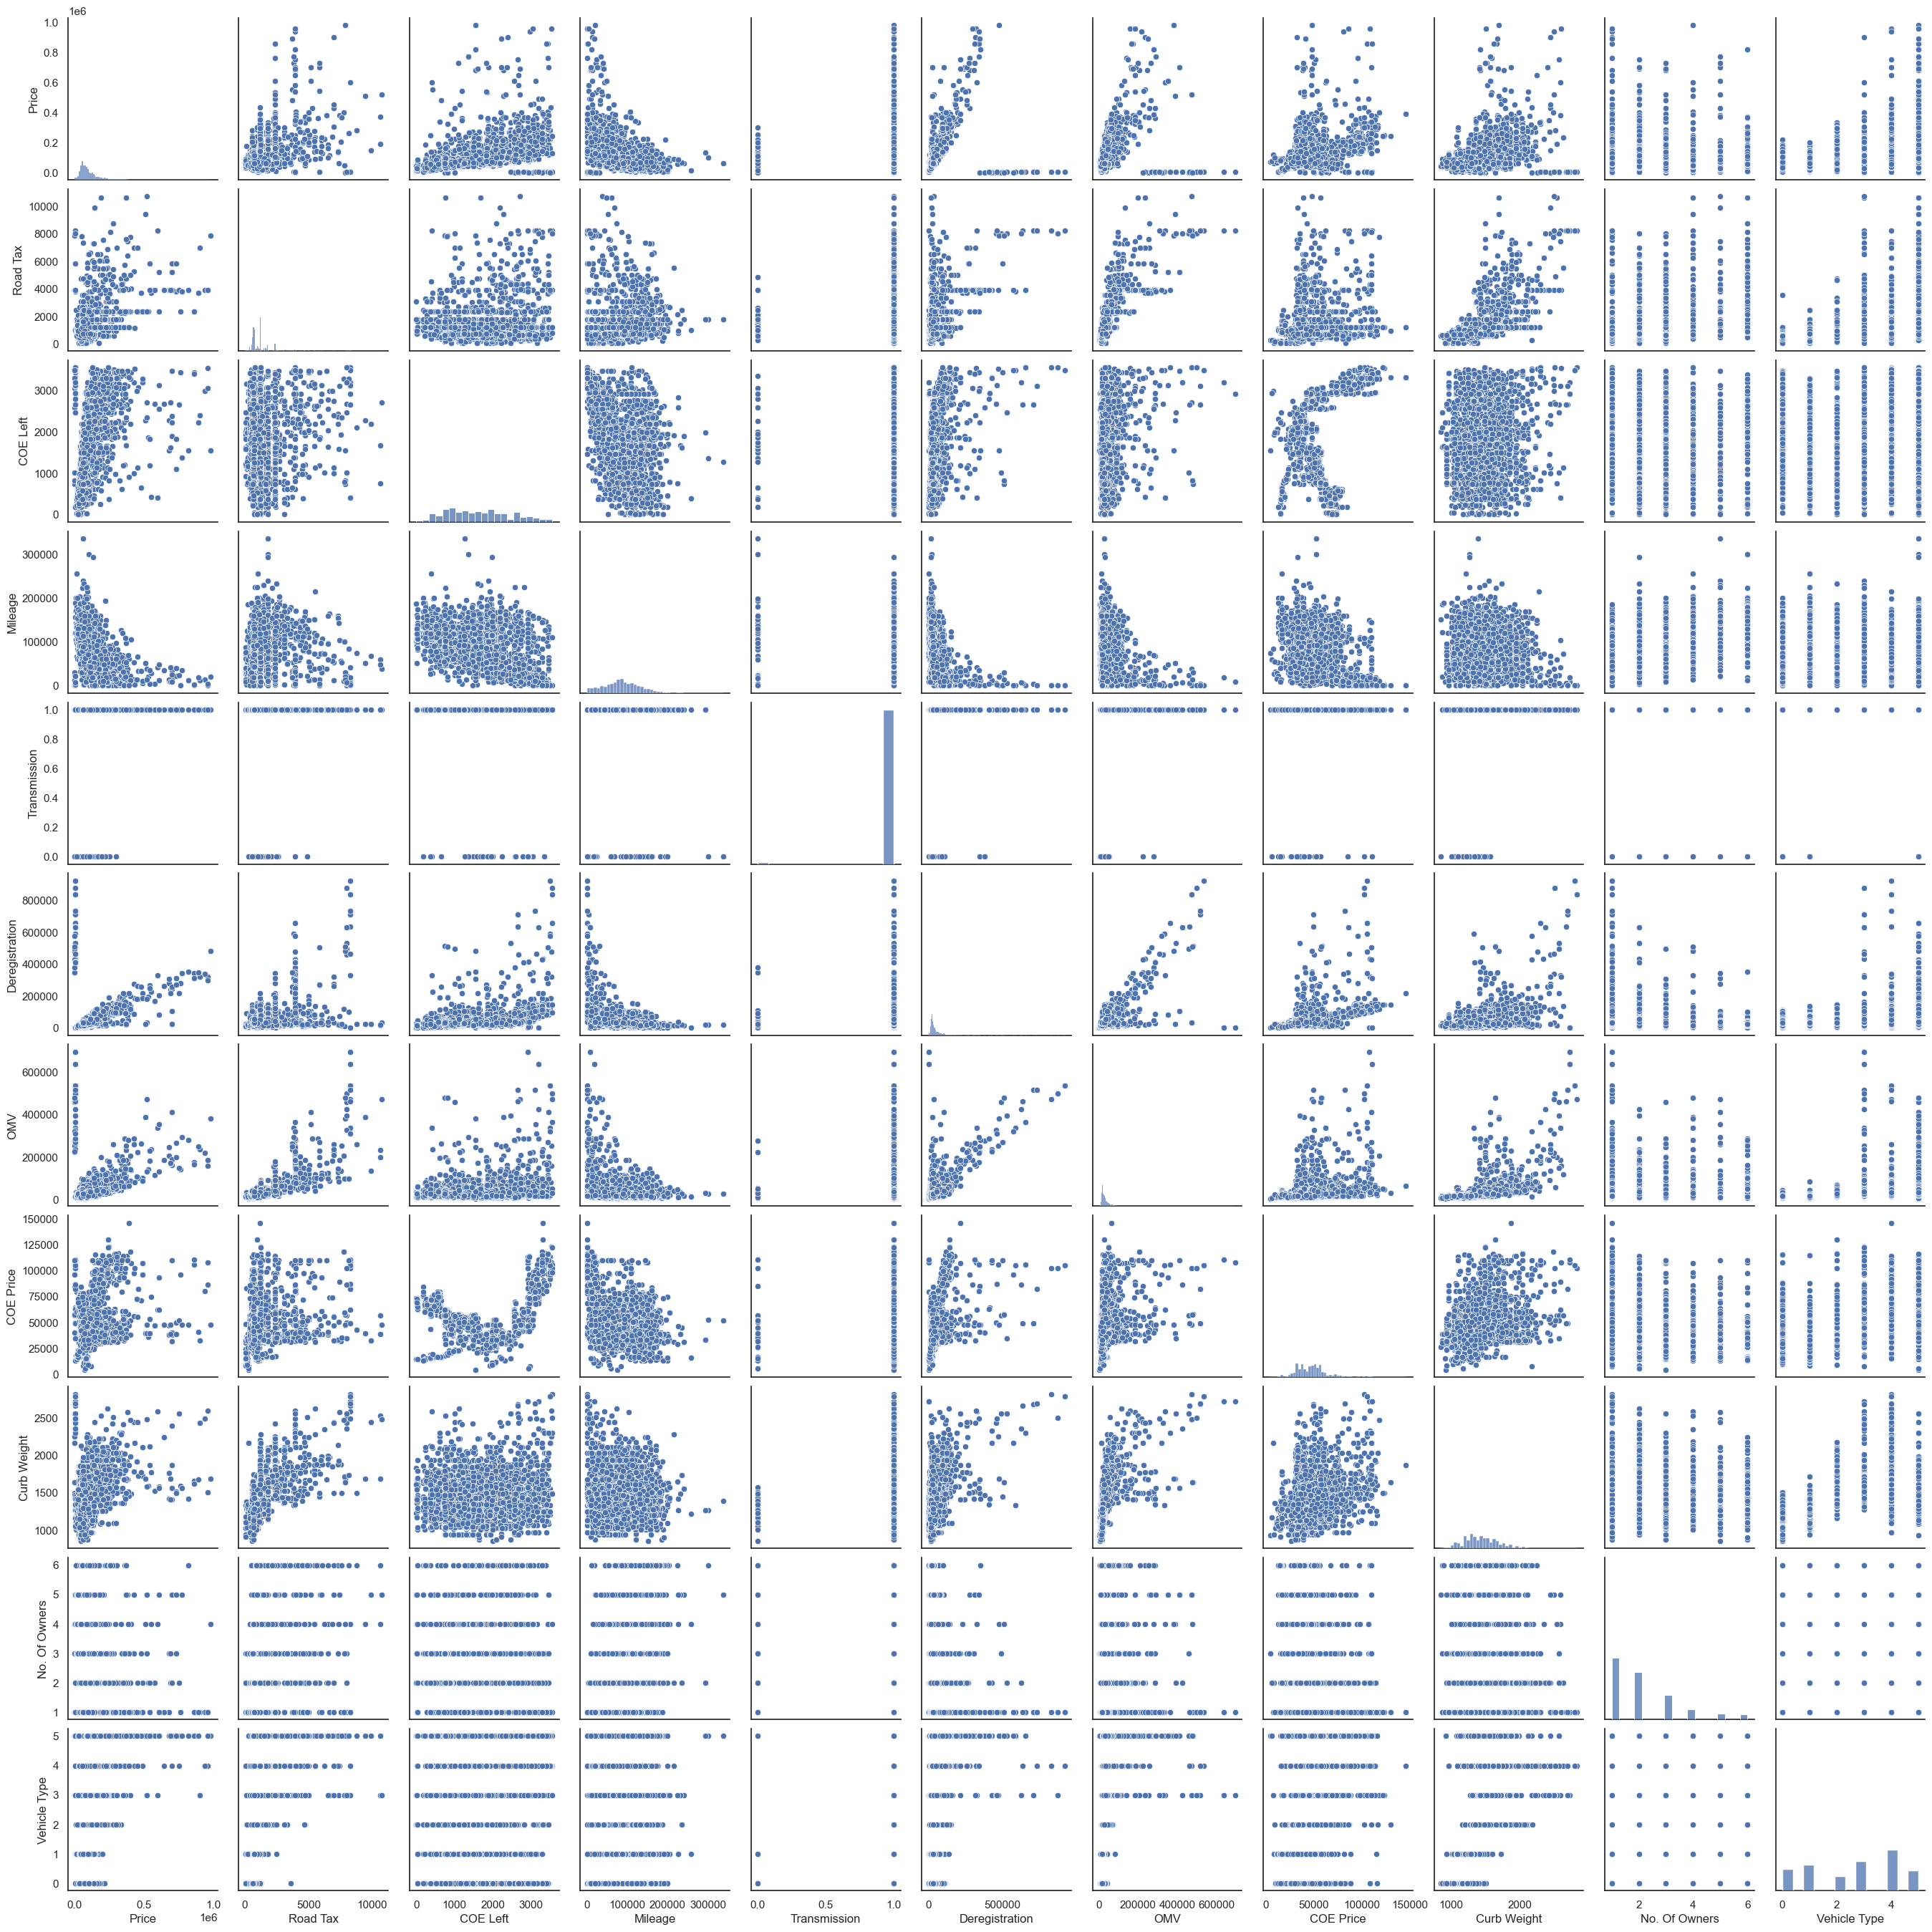

In [296]:
#after dropping 'Depreciation','Registration Date','Manufacture Year','ARF','Engine Capacity','Power'
sns.pairplot(data_rm_brand);

In [300]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Load the data
data = pd.read_csv('remaining_columns.csv')

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data.drop('Price', axis=1), data['Price'], test_size=0.25, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the R2 score
r2_score = r2_score(y_test, y_pred)

# Print the R2 score
print('R2 score:', r2_score)

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values